# Regression Deep Learning Model for Song Year Prediction Using TensorFlow Take 3
### David Lowe
### March 9, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Song Year Prediction dataset is a classic regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: This data is a subset of the Million Song Dataset, http://labrosa.ee.columbia.edu/millionsong/, a collaboration between LabROSA (Columbia University) and The Echo Nest. The purpose of this exercise is to predict the release year of a song from audio features. Songs are mostly western, commercial tracks ranging from 1922 to 2011, with a peak in the year 2000s. The data preparer recommended the train/test split of the first 463,715 examples for training and the last 51,630 examples for testing. This approach avoids the 'producer effect' by making sure no song from a given artist ends up in both the train and test set.

In iteration Take1, we constructed several Multilayer Perceptron (MLP) models with one hidden layer of 16, 32, 64, and 128 nodes. The single-layer MLP model serves as the baseline model as we build more complex MLP models in future iterations.

In iteration Take2, we constructed several Multilayer Perceptron (MLP) models with two hidden layers. We observed the effects of having the additional layer in our MLP models.

In this Take3 iteration, we will construct several Multilayer Perceptron (MLP) models with three hidden layers. We will observe whether the additional layer can improve the RMSE as we build more complex MLP models in future iterations.

ANALYSIS: In iteration Take1, all models processed the test dataset and produced RMSEs that are around 9.50. However, the single-layer models do not exhibit a stable curve when making predictions with the test dataset.

In iteration Take2, all models processed the test dataset and again produced RMSEs that are around 9.50. Moreover, the dual-layer models also did not exhibit a stable curve when making predictions with the test dataset.

In this Take3 iteration, all models processed the test dataset and again produced RMSEs that are around 9.50. Moreover, the tri-layer models also did not exhibit a stable curve when making predictions with the test dataset.

CONCLUSION: For this iteration, the different model architectures produced similar RMSE. For this dataset, we should consider experimenting more MLP models with some regularization techniques.

Dataset Used: YearPredictionMSD Dataset

Dataset ML Model: Regression with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD

Thierry Bertin-Mahieux, Daniel P.W. Ellis, Brian Whitman, and Paul Lamere. The Million Song Dataset. In Proceedings of the 12th International Society for Music Information Retrieval Conference (ISMIR 2011), 2011.

One potential source of performance benchmarks: https://www.kaggle.com/uciml/msd-audio-features/home

Any deep-learning modeling project genrally can be broken down into about seven major tasks:

0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Retrieve GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sun Mar  1 02:20:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
# Set the random seed number for reproducible results
seedNum = 888

In [0]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

In [5]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'mean_squared_error'
default_optimizer = tf.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.initializers.GlorotNormal(seed=seedNum)
default_epoch = 50
default_batch = 32

Num GPUs Available:  1


In [0]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Regression Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [0]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [0]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/ucirvine-year-prediction-msd/YearPredictionMSD.txt'
attrNames = ['attr' + str(i) for i in range(1,91)]
colNames = ['targetVar'] + attrNames
Xy_original = pd.read_csv(dataset_path, sep=',', names=colNames, header=None, index_col=False)

# Take a peek at the dataframe after the import
Xy_original.head(10)

,targetVar,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,attr65,attr66,attr67,attr68,attr69,attr70,attr71,attr72,attr73,attr74,attr75,attr76,attr77,attr78,attr79,attr80,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-3

In [11]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
targetVar    515345 non-null int64
attr1        515345 non-null float64
attr2        515345 non-null float64
attr3        515345 non-null float64
attr4        515345 non-null float64
attr5        515345 non-null float64
attr6        515345 non-null float64
attr7        515345 non-null float64
attr8        515345 non-null float64
attr9        515345 non-null float64
attr10       515345 non-null float64
attr11       515345 non-null float64
attr12       515345 non-null float64
attr13       515345 non-null float64
attr14       515345 non-null float64
attr15       515345 non-null float64
attr16       515345 non-null float64
attr17       515345 non-null float64
attr18       515345 non-null float64
attr19       515345 non-null float64
attr20       515345 non-null float64
attr21       515345 non-null float64
attr22       515345 non-null float64
attr23       515345 non-null float64
att

In [12]:
Xy_original.describe()

,targetVar,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,attr65,attr66,attr67,attr68,attr69,attr70,attr71,attr72,attr73,attr74,attr75,attr76,attr77,attr78,attr79,attr80,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,-0.146527,2.546063,33.714006,2439.359375,1967.734202,1514.859902,910.981344,879.146721,603.737434,517.579339,393.962215,325.733170,288.885085,291.973238,43.031969,43.314873,-46.449006,-27.672783,14.958491,44.514859,5.131786,24.034309,9.498816,-4.178856,0.499475,72.652267,-51.441256,117.921056,-189.880885,...,6.378511,28.294082,12.772241,1.700474,-10.205155,64.101262,104.822085,-0.026481,38.678040,-27.989985,3.301739,0.307127,-0.478828,-138.223224,-0.696065,0.242582,3.151751,27.642745,31.822244,-0.835950,-8.931564,4.849253,-27.347646,-11.938792,-21.572137,-5.576196,-23.304324,31.113053,-104.974794,26.962393,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,4.370848,8.320190,22.259632,1749.367690,1261.484792,1092.831044,475.708203,576.865994,317.499288,309.364735,214.013502,165.699383,186.960729,153.475649,121.429498,715.759147,544.879865,218.368476,163.215789,134.887832,99.088119,71.809934,74.411680,53.517036,42.490396,107.912629,415.039100,453.399231,260.645370,...,93.555672,75.049277,69.981849,83.278660,57.806591,273.827189,311.135298,266.774027,169.072163,144.083035,59.447204,49.181425,37.675424,308.187390,222.198519,128.140961,99.920949,116.696176,106.359938,36.799193,251.606754,229.060421,163.782620,63.288891,64.691545,26.358175,268.190912,144.156203,201.137522,123.847891,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,-69.680870,-94.041960,0.132830,8.474200,21.214350,17.857900,12.150420,5.517710,19.808810,6.254870,6.183760,15.307500,6.116440,5.177340,-2821.430210,-13390.360690,-12017.088870,-4324.864700,-3357.279900,-3115.374560,-3805.666170,-1516.356440,-1679.118320,-1590.637130,-989.645800,-1711.484000,-8448.194880,-10095.725950,-9803.759040,...,-2270.811070,-1746.478220,-3188.177380,-2199.782210,-1694.260320,-5154.024360,-5111.601750,-4730.599100,-3756.490790,-2499.954680,-1900.104800,-1396.701680,-600.090760,-10

In [13]:
Xy_original.isnull().sum()

targetVar    0
attr1        0
attr2        0
attr3        0
attr4        0
            ..
attr86       0
attr87       0
attr88       0
attr89       0
attr90       0
Length: 91, dtype: int64

In [14]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 1.b) Data Cleaning

In [15]:
# Not applicable for this iteration of modeling

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,targetVar,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,attr65,attr66,attr67,attr68,attr69,attr70,attr71,attr72,attr73,attr74,attr75,attr76,attr77,attr78,attr79,attr80,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-3

In [16]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
targetVar    515345 non-null int64
attr1        515345 non-null float64
attr2        515345 non-null float64
attr3        515345 non-null float64
attr4        515345 non-null float64
attr5        515345 non-null float64
attr6        515345 non-null float64
attr7        515345 non-null float64
attr8        515345 non-null float64
attr9        515345 non-null float64
attr10       515345 non-null float64
attr11       515345 non-null float64
attr12       515345 non-null float64
attr13       515345 non-null float64
attr14       515345 non-null float64
attr15       515345 non-null float64
attr16       515345 non-null float64
attr17       515345 non-null float64
attr18       515345 non-null float64
attr19       515345 non-null float64
attr20       515345 non-null float64
attr21       515345 non-null float64
attr22       515345 non-null float64
attr23       515345 non-null float64
att

In [17]:
Xy_original.describe()

,targetVar,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,attr65,attr66,attr67,attr68,attr69,attr70,attr71,attr72,attr73,attr74,attr75,attr76,attr77,attr78,attr79,attr80,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,-0.146527,2.546063,33.714006,2439.359375,1967.734202,1514.859902,910.981344,879.146721,603.737434,517.579339,393.962215,325.733170,288.885085,291.973238,43.031969,43.314873,-46.449006,-27.672783,14.958491,44.514859,5.131786,24.034309,9.498816,-4.178856,0.499475,72.652267,-51.441256,117.921056,-189.880885,...,6.378511,28.294082,12.772241,1.700474,-10.205155,64.101262,104.822085,-0.026481,38.678040,-27.989985,3.301739,0.307127,-0.478828,-138.223224,-0.696065,0.242582,3.151751,27.642745,31.822244,-0.835950,-8.931564,4.849253,-27.347646,-11.938792,-21.572137,-5.576196,-23.304324,31.113053,-104.974794,26.962393,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,4.370848,8.320190,22.259632,1749.367690,1261.484792,1092.831044,475.708203,576.865994,317.499288,309.364735,214.013502,165.699383,186.960729,153.475649,121.429498,715.759147,544.879865,218.368476,163.215789,134.887832,99.088119,71.809934,74.411680,53.517036,42.490396,107.912629,415.039100,453.399231,260.645370,...,93.555672,75.049277,69.981849,83.278660,57.806591,273.827189,311.135298,266.774027,169.072163,144.083035,59.447204,49.181425,37.675424,308.187390,222.198519,128.140961,99.920949,116.696176,106.359938,36.799193,251.606754,229.060421,163.782620,63.288891,64.691545,26.358175,268.190912,144.156203,201.137522,123.847891,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,-69.680870,-94.041960,0.132830,8.474200,21.214350,17.857900,12.150420,5.517710,19.808810,6.254870,6.183760,15.307500,6.116440,5.177340,-2821.430210,-13390.360690,-12017.088870,-4324.864700,-3357.279900,-3115.374560,-3805.666170,-1516.356440,-1679.118320,-1590.637130,-989.645800,-1711.484000,-8448.194880,-10095.725950,-9803.759040,...,-2270.811070,-1746.478220,-3188.177380,-2199.782210,-1694.260320,-5154.024360,-5111.601750,-4730.599100,-3756.490790,-2499.954680,-1900.104800,-1396.701680,-600.090760,-10

In [18]:
Xy_original.isnull().sum()

targetVar    0
attr1        0
attr2        0
attr3        0
attr4        0
            ..
attr86       0
attr87       0
attr88       0
attr89       0
attr90       0
Length: 91, dtype: int64

In [19]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [0]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [21]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (515345, 91) X_original.shape: (515345, 90) y_original.shape: (515345,)


In [0]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

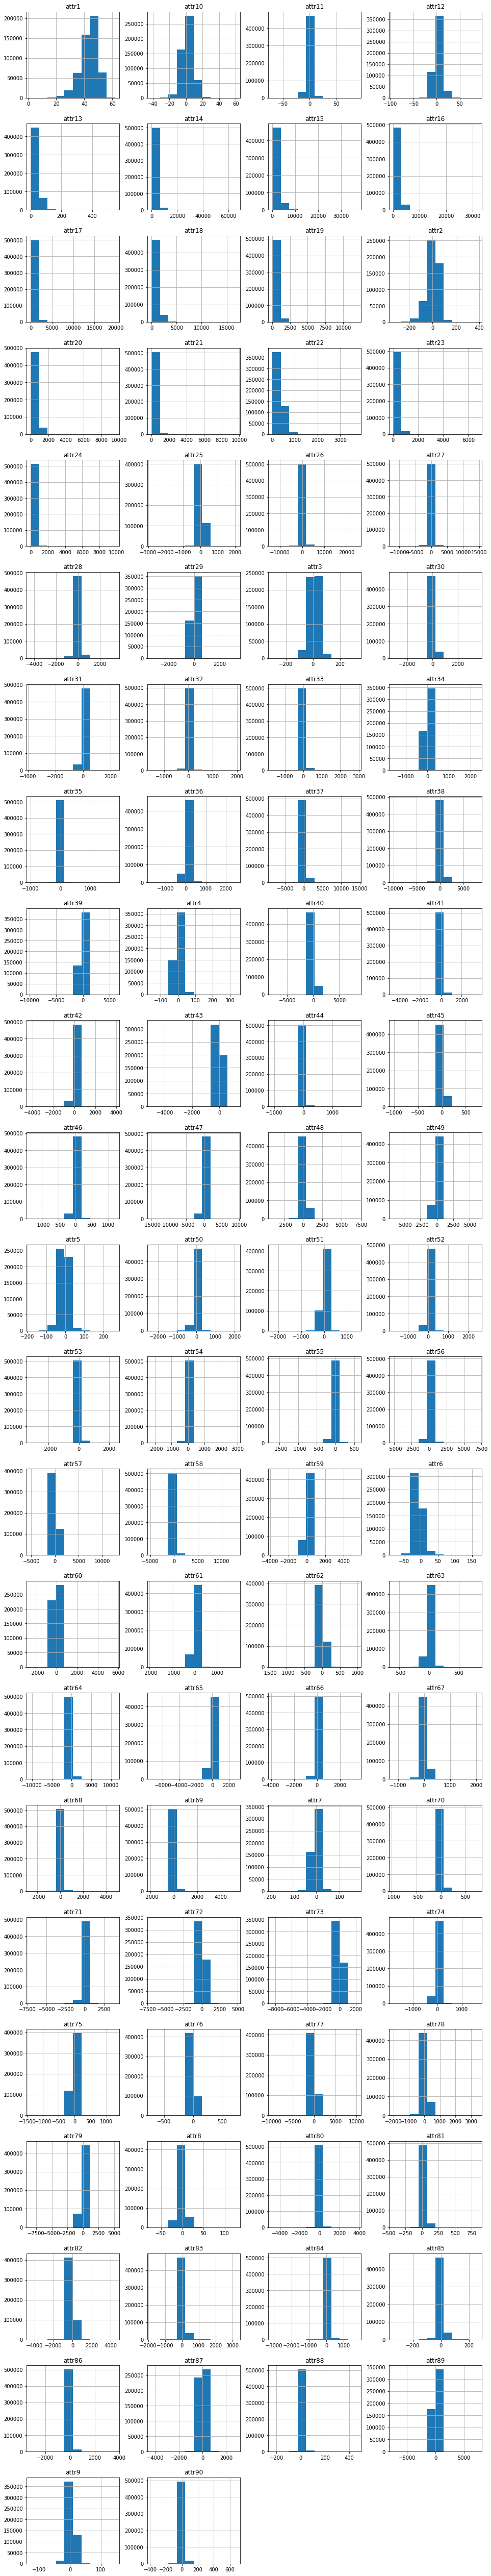

In [23]:
# Histograms for each attribute before pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [24]:
tobe_transformed_cols = X_original.columns.tolist()
# tobe_transformed_cols.remove('some_column_label')
print(tobe_transformed_cols)

['attr1', 'attr2', 'attr3', 'attr4', 'attr5', 'attr6', 'attr7', 'attr8', 'attr9', 'attr10', 'attr11', 'attr12', 'attr13', 'attr14', 'attr15', 'attr16', 'attr17', 'attr18', 'attr19', 'attr20', 'attr21', 'attr22', 'attr23', 'attr24', 'attr25', 'attr26', 'attr27', 'attr28', 'attr29', 'attr30', 'attr31', 'attr32', 'attr33', 'attr34', 'attr35', 'attr36', 'attr37', 'attr38', 'attr39', 'attr40', 'attr41', 'attr42', 'attr43', 'attr44', 'attr45', 'attr46', 'attr47', 'attr48', 'attr49', 'attr50', 'attr51', 'attr52', 'attr53', 'attr54', 'attr55', 'attr56', 'attr57', 'attr58', 'attr59', 'attr60', 'attr61', 'attr62', 'attr63', 'attr64', 'attr65', 'attr66', 'attr67', 'attr68', 'attr69', 'attr70', 'attr71', 'attr72', 'attr73', 'attr74', 'attr75', 'attr76', 'attr77', 'attr78', 'attr79', 'attr80', 'attr81', 'attr82', 'attr83', 'attr84', 'attr85', 'attr86', 'attr87', 'attr88', 'attr89', 'attr90']


In [25]:
# Apply feature scaling and transformation
X_original = X_original.astype(float)
scaler = preprocessing.StandardScaler()
X_original[tobe_transformed_cols] = scaler.fit_transform(X_original[tobe_transformed_cols])

X_original.head(-10)

,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,attr40,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,attr65,attr66,attr67,attr68,attr69,attr70,attr71,attr72,attr73,attr74,attr75,attr76,attr77,attr78,attr79,attr80,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
0,1.080575,0.391265,1.826532,0.464657,-0.474730,-0.278204,-1.552371,-1.310845,0.387704,-0.666166,0.793414,-0.584275,-1.056103,-1.045093,-0.805912,-0.747368,-1.055262,-0.858844,-0.873144,-0.903356,-0.666024,-0.836212,-1.008012,-0.734829,-0.423683,-0.504619,0.261180,0.347007,-0.677763,-0.463919,-0.031910,0.144689,0.029940,0.103645,0.171685,-0.676680,-0.198144,-0.443721,0.585406,0.242786,...,-0.339481,-0.429076,0.007435,0.478516,0.050901,-0.310816,0.002206,0.241122,-0.074484,-0.115219,-0.195271,0.155139,-0.272267,0.138797,-0.366056,-0.279650,0.015447,0.371165,-0.035078,0.186311,-0.112104,-0.200706,0.115638,0.302385,0.200496,-0.012610,0.040941,-0.113944,0.251836,0.106465,-0.085335,0.108508,0.142775,-0.237355,0.049233,-0.356182,0.544458,-0.470599,-0.255977,0.042292
1,0.880919,0.332292,1.748539,0.721828,-0.164945,-1.191173,0.765681,0.109626,1.420941,0.414950,0.541252,-0.265139,0.479611,-0.218605,-1.079941,-0.967624,-0.281324,-0.803477,0.449577,-0.488505,-0.355738,-0.317769,-0.786935,0.165365,-0.193934,-0.151685,0.383939,0.744982,-0.681570,-0.974102,0.123618,0.304598,0.309095,-0.535819,1.049858,-0.424444,-0.605081,-0.352097,0.195786,0.870474,...,0.236999,-0.356714,0.831972,-0.544332,-0.559539,0.240032,-0.079926,-0.326565,-0.499388,-0.262564,-0.794017,-0.401863,0.346923,-0.874203,0.196257,0.092991,-0.916031,0.125195,0.137927,-0.797342,0.218263,0.548457,0.251739,0.125429,0.609536,-0.483539,-0.241197,-0.116109,0.409042,-0.692585,-0.314250,0.306236,-0.069483,0.052017,-0.632328,-0.436057,0.556448,0.568744,0.206940,1.158587
2,1.247622,0.592600,1.337173,0.750657,-0.001110,-0.702100,-0.060914,-0.069956,1.166254,-0.074608,0.659382,-0.206489,-1.179183,-0.994540,-0.754449,-0.842576,-1.167197,-0.644427,-0.680438,-0.744836,-1.315763,-0.990010,-0.774182,-0.603851,-0.389326,-0.475469,-0.187041,0.090331,-0.206321,-0.235303,-0.307898,-0.199418,-0.125792,0.578809,0.136693,-0.407285,-0.056498,-0.897922,0.090621,-0.048620,...,0.129665,-0.150860,0.164243,-0.146597,0.026313,-0.034123,0.289001,0.029936,-0.336572,0.194712,-0.099793,0.522931,0.059352,-0.402827,-1.048185,-0.021442,-0.153067,0.460456,-0.279680,-0.026845,0.765419,0.077703,-0.077183,0.873971,-0.154506,0.026094,-0.049322,-0.381945,0.103323,0.315248,-0.396186,0.566683,-0.756534,-0.284019,-0.024220,0.223128,-0.509789,-0.338457,0.105819,-0.090208
3,0.801044,-0.061805,0.783683,0.087218,0.329180,-1.298429,0.510714,-1.073355,-0.016803,-1.262655,1.550430,-0.708817,0.176411,-0.151642,-1.006990,-0.965945,-0.353561,-1.126500,-0.679815,-0.867950,-0.691843,-0.902406,-1.016593,-0.918716,0.292010,-0.147141,0.165074,-0.314855,-0.759269,-0.224530,0.094966,-0.662728,-0.656730,-0.736462,0.478642,-0.342991,-0.313003,-0.466669,0.381073,-0.112344,...,-0.019340,-0.874318,-0.123184,0.126595,0.782474,-0.887411,-0.071854,-0.076723,0.373259,0.056994,-0.417653,0.062135,-0.296027,0.615786,-0.224483,-0.221554,-0.863781,-0.299885,-0.507121,0.054858,-0.452187,0.636184,0.315799,0.839595,-0.239151,-0.878425,0.691674,-0.061946,0.478975,0.470511,0.586237,-0.559427,-0.478689,-0.890161,-0.793906,0.567269,-0.263107,0.408116,0.967862,0.793384
4,1.249775,0.793334,1.657037,0.447460,-0.406775,-0.567138,-0.692498,-0.952197,0.841844,-0.144910,0.401697,-0.042527,0.611278,-0.883220,-0.917862,-1.094474,-1.000481,-0.931815,-0.848601,-0.628978,-0.950142,-0.542465,-1.026901,-0.530277,-0.308223,-0.339436,0.461216,-0.226700,-0.494780,-0.381546,-0.174435,-0.388365,0.150394,-0.301324,0.862572,-0.569401,-

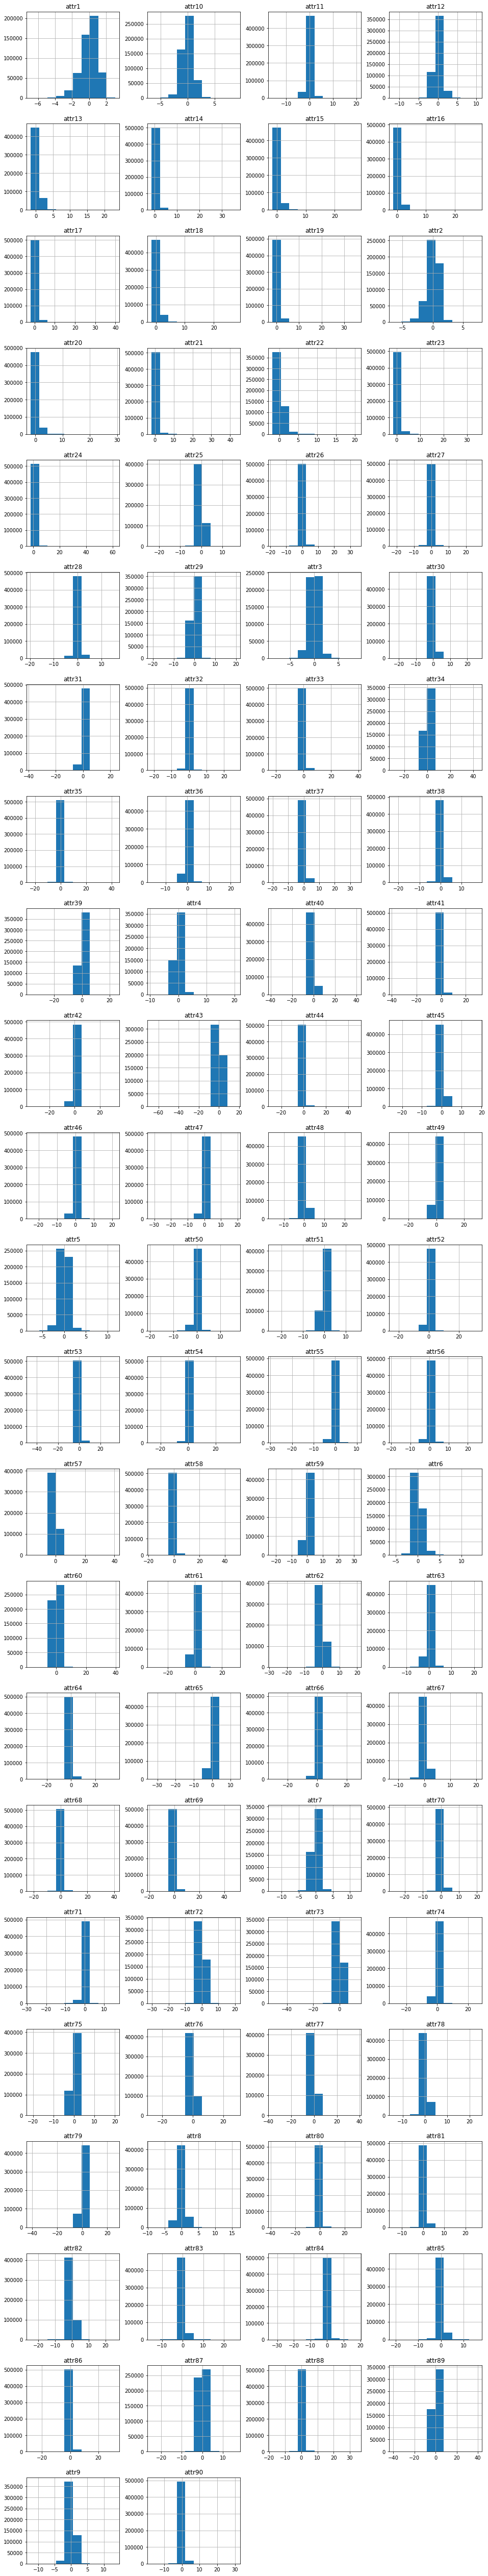

In [26]:
# Histograms for each attribute after pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

## 1.d) Splitting Data into Training and Test Sets

In [0]:
# Perform one-hot-encoding before splitting into trainig and test
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [28]:
X_encoded = X_original.to_numpy()
y_encoded = y_original.to_numpy()
# if (splitDataset):
#     X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, random_state=seedNum)
# else:
#     X_train, y_train = X_encoded, y_encoded
#     X_test, y_test = X_encoded, y_encoded

split_point = 463715
X_train = X_encoded[:split_point]
y_train = y_encoded[:split_point]
X_test = X_encoded[split_point:]
y_test = y_encoded[split_point:]
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (463715, 90) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (463715,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (51630, 90) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (51630,) y_test.type: <class 'numpy.ndarray'>


In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Not applicable for this iteration of modeling

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Not applicable for this iteration of modeling

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Explore Different One-Layer Models

In [0]:
if (notifyStatus): email_notify("Phase 4 Explore Different One-Layer Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 57s 122us/sample - loss: 149663.3567 - val_loss: 207.8905
Epoch 2/50
463715/463715 [==============================] - 55s 118us/sample - loss: 203.1777 - val_loss: 164.6238
Epoch 3/50
463715/463715 [==============================] - 54s 117us/sample - loss: 165.3985 - val_loss: 110.4346
Epoch 4/50
463715/463715 [==============================] - 54s 117us/sample - loss: 144.0489 - val_loss: 133.6704
Epoch 5/50
463715/463715 [==============================] - 54s 116us/sample - loss: 138.9300 - val_loss: 100.5367
Epoch 6/50
463715/463715 [==============================] - 54s 115us/sample - loss: 140.8374 - val_loss: 116.5290
Epoch 7/50
463715/463715 [==============================] - 53s 114us/sample - loss: 137.9850 - val_loss: 117.1095
Epoch 8/50
463715/463715 [==============================] - 53s 115us/sample - loss: 135.2554 - val_loss: 109.1979
Epoch 9/50
463715/463715 [

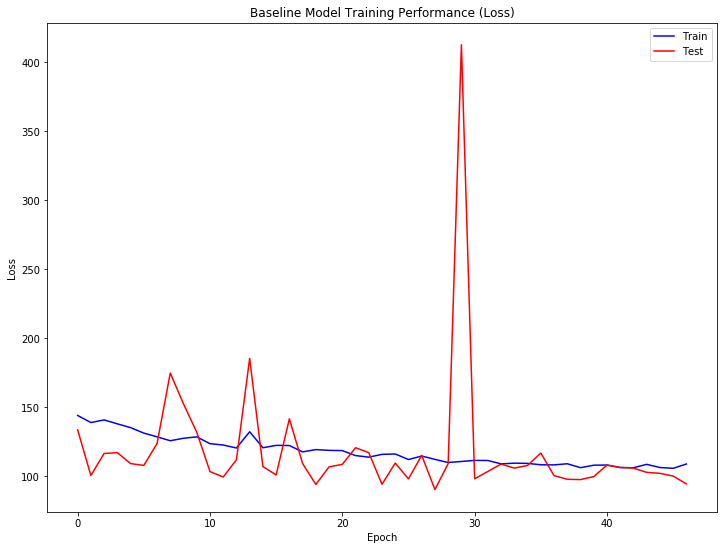

In [37]:
# Define MLP model #3A
def create_model_3A():
    default_model = Sequential()
    default_model.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(8, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(4, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_3A = create_model_3A()
extra_epochs = 0
baseline_hist = baseline_model_3A.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 55s 118us/sample - loss: 44883.7280 - val_loss: 183.5974
Epoch 2/50
463715/463715 [==============================] - 56s 120us/sample - loss: 234.8113 - val_loss: 135.0691
Epoch 3/50
463715/463715 [==============================] - 55s 118us/sample - loss: 193.1891 - val_loss: 163.9370
Epoch 4/50
463715/463715 [==============================] - 55s 119us/sample - loss: 163.0790 - val_loss: 126.3744
Epoch 5/50
463715/463715 [==============================] - 55s 119us/sample - loss: 158.0832 - val_loss: 116.5533
Epoch 6/50
463715/463715 [==============================] - 56s 121us/sample - loss: 164.0133 - val_loss: 120.4154
Epoch 7/50
463715/463715 [==============================] - 55s 119us/sample - loss: 154.3895 - val_loss: 115.0056
Epoch 8/50
463715/463715 [==============================] - 54s 117us/sample - loss: 155.5904 - val_loss: 148.1905
Epoch 9/50
463715/463715 [=

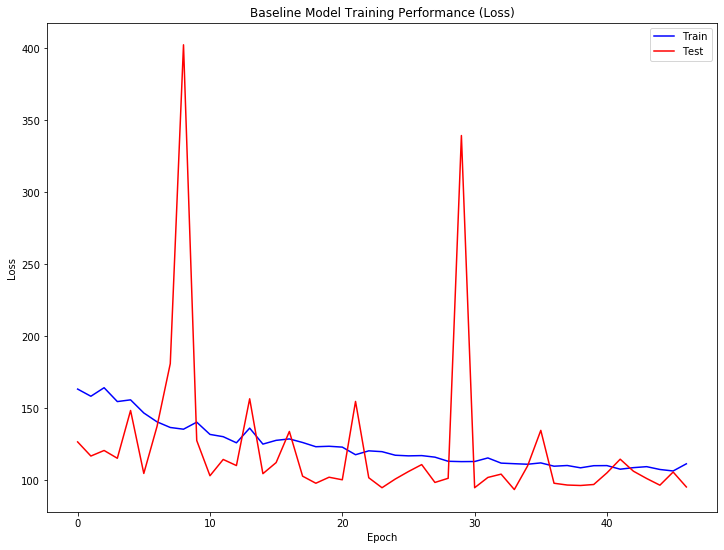

In [38]:
# Define MLP model #3B
def create_model_3B():
    default_model = Sequential()
    default_model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(8, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_3B = create_model_3B()
extra_epochs = 0
baseline_hist = baseline_model_3B.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 3
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 56s 121us/sample - loss: 26849.0706 - val_loss: 176.3172
Epoch 2/50
463715/463715 [==============================] - 54s 117us/sample - loss: 291.5590 - val_loss: 172.9335
Epoch 3/50
463715/463715 [==============================] - 56s 120us/sample - loss: 232.7596 - val_loss: 132.9543
Epoch 4/50
463715/463715 [==============================] - 55s 118us/sample - loss: 200.1591 - val_loss: 192.0353
Epoch 5/50
463715/463715 [==============================] - 56s 121us/sample - loss: 186.0194 - val_loss: 144.0894
Epoch 6/50
463715/463715 [==============================] - 56s 121us/sample - loss: 184.6690 - val_loss: 167.4417
Epoch 7/50
463715/463715 [==============================] - 55s 118us/sample - loss: 168.6237 - val_loss: 119.2268
Epoch 8/50
463715/463715 [==============================] - 55s 119us/sample - loss: 182.0823 - val_loss: 240.9568
Epoch 9/50
463715/463715 [=

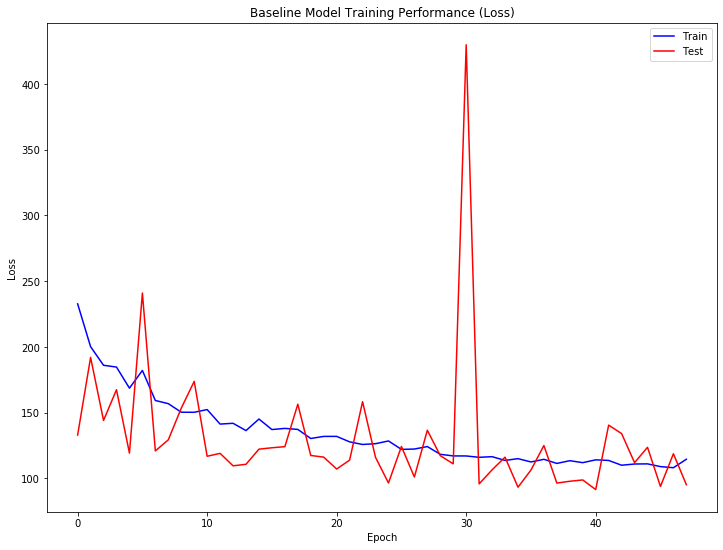

In [39]:
# Define MLP model #3C
def create_model_3C():
    default_model = Sequential()
    default_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_3C = create_model_3C()
extra_epochs = 0
baseline_hist = baseline_model_3C.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 2
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 56s 121us/sample - loss: 18529.9726 - val_loss: 303.0016
Epoch 2/50
463715/463715 [==============================] - 57s 123us/sample - loss: 390.2321 - val_loss: 190.8397
Epoch 3/50
463715/463715 [==============================] - 56s 121us/sample - loss: 286.8797 - val_loss: 143.0438
Epoch 4/50
463715/463715 [==============================] - 57s 123us/sample - loss: 247.1737 - val_loss: 340.9121
Epoch 5/50
463715/463715 [==============================] - 56s 120us/sample - loss: 224.4900 - val_loss: 142.9121
Epoch 6/50
463715/463715 [==============================] - 57s 124us/sample - loss: 223.9359 - val_loss: 170.8657
Epoch 7/50
463715/463715 [==============================] - 57s 122us/sample - loss: 206.4646 - val_loss: 144.6334
Epoch 8/50
463715/463715 [==============================] - 56s 121us/sample - loss: 219.5440 - val_loss: 186.1219
Epoch 9/50
463715/463715 [=

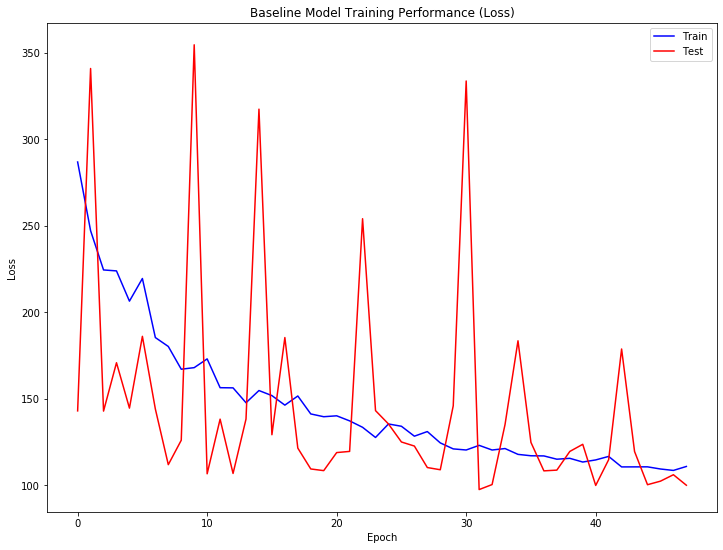

In [40]:
# Define MLP model #3D
def create_model_3D():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_3D = create_model_3D()
extra_epochs = 0
baseline_hist = baseline_model_3D.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')

# Summarize model training hisotry
begin_epoch = 2
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
if (notifyStatus): email_notify("Phase 4 Explore Different One-Layer Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [0]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [43]:
# Display a summary of the final model
final_model = baseline_model_3A
print(final_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1456      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 90), 'dtype': 'float32', 'units': 16, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotNormal', 'config': {'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotNormal', 'config': {'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_2', 'trainable': True, 'dtype': 'float32',

In [0]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [46]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 3:04:52.951932
